# SDB

Тип монитора: Фьючерсы кроме CBOT - 1, CBOT - 2, Stocks - 3     3
[*********************100%***********************]  1 of 1 completed
IV/HV: 1.21
******************************************************************************************************************
          FOR SHORT:
Базовый актив: GLD
Серия: 2022-09-30
Матожидание положительной сделки: 87.59 %
Прибыль: 34.66
Риск: -33.4


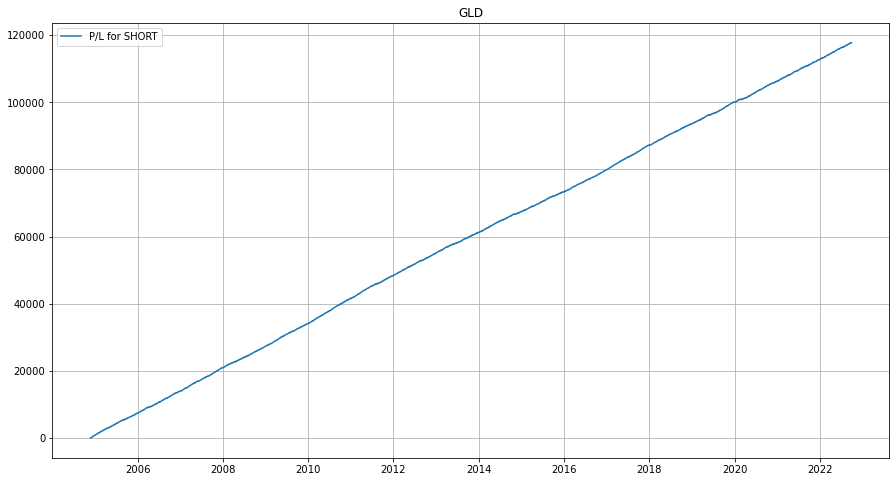

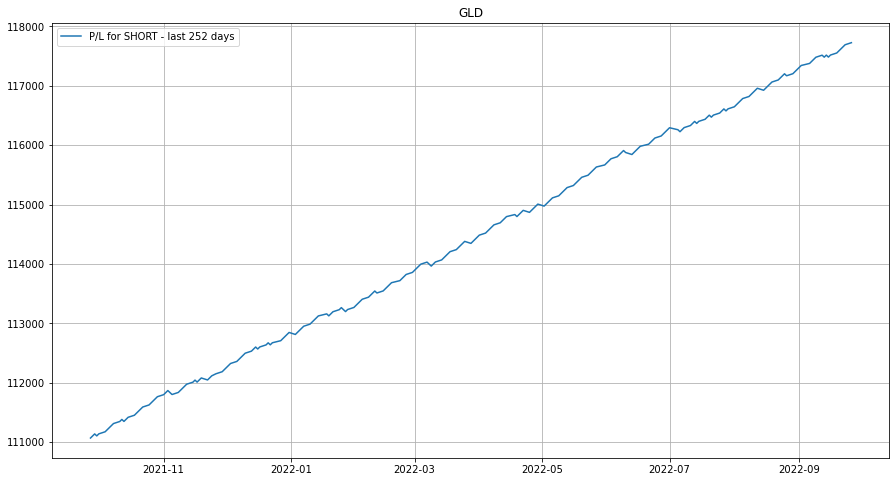

******************************************************************************************************************
UP stoploss: 155.5
DOWN stoploss: 147.5


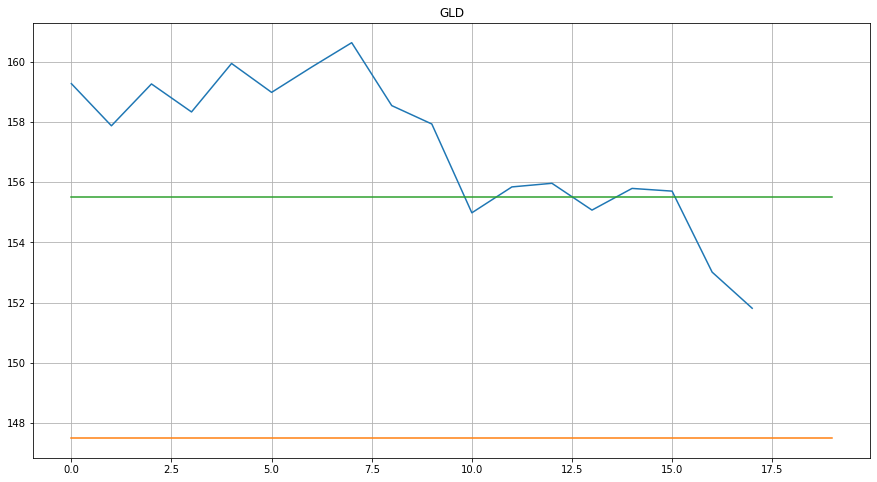

[*********************100%***********************]  1 of 1 completed
******************************************************************************************************************


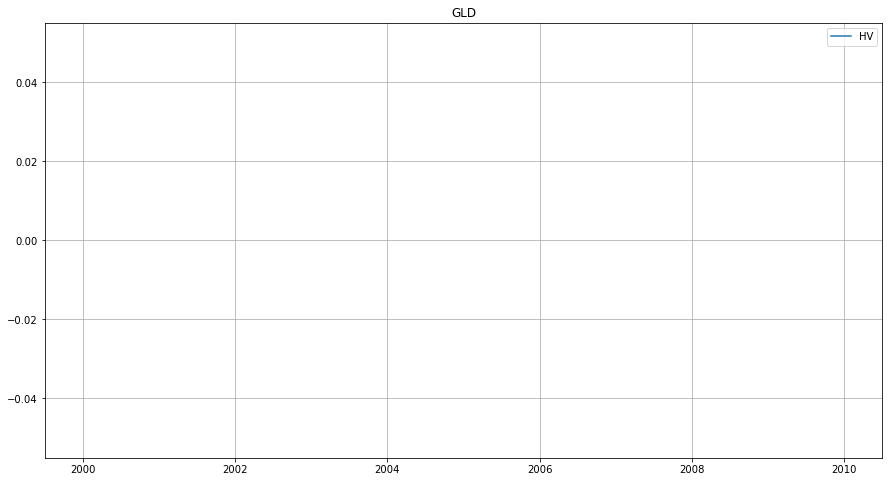

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import HTML

# функции для построения графиков
def my_chart_1(series, title, label):
    plt.figure(figsize=(15,8))
    plt.plot(series, label=label)
    plt.legend()
    plt.grid()
    plt.title(title)
    return plt.show()


def my_chart_2(series, title):
    plt.figure(figsize=(15,8))
    plt.plot(series)
    plt.grid()
    plt.title(title)
    return plt.show()

#вводное окно для типа инструмента
type_1 = int(input('Тип монитора: Фьючерсы кроме CBOT - 1, CBOT - 2, Stocks - 3     '))
way = 'D:\\Работы\\Опционы Америка\\8_DSB\\'

if type_1 == 1:
    excel_df = pd.read_excel(
        f'{way}DB.xlsx',
        sheet_name='JN')
elif type_1 == 2:
    excel_df = pd.read_excel(
        f'{way}DB - CBOT.xlsx',
        sheet_name='JN')
elif type_1 == 3:
    excel_df = pd.read_excel(
        f'{way}DB - stocks(2).xlsx',
        sheet_name='JN')

#перечень фьючерсов для ввода    
futures = ['ES', 'NQ', 'RTY', 'ZW', 'ZC', 'ZS', 'CL', 'GC', 'NG']

ba_0 = str(excel_df['BA'][0])
if ba_0 in futures:
    ba = ba_0 + '=F'
else:
    ba = ba_0

#собираем данные из таблицы эксель    
exp_date = str(excel_df['Exp date'][0])
days = int(excel_df['DTE'])
plus = float(excel_df['Profit'])
minus = float(excel_df['Loss']) * -1

exp_be_minus = float(excel_df['Exp BE-'])
exp_be_plus = float(excel_df['Exp BE+'])
exp_t_be_minus = float(excel_df['Exp-t BE-'])
exp_t_be_plus = float(excel_df['Exp-t BE+'])
down_take = float(excel_df['Down'])
up_take = float(excel_df['Up'])

#собираем данные с yahoo finance 
df_yahoo = yf.download(ba, start='2001-01-01', interval='1d')
open_0 = df_yahoo['Open']
close = df_yahoo['Close']
high = df_yahoo['High']
low = df_yahoo['Low']

#считаем необходимые параметры
ups = close.rolling(window=days).max()
downs = close.rolling(window=days).min()

close_to_close = close.pct_change(periods=1).rolling(window=days).std() * np.sqrt(365) / np.sqrt(252 / days) * 100
high_low = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=days, adjust=False).mean() / np.sqrt(252 / days) * 100
my_vol = round((high_low * 0.8 + close_to_close * 0.2) * 1.5, 2)

df_yahoo['Volatility'] = my_vol
df_yahoo['UPs'] = ups
df_yahoo['DOWNs'] = downs

#формируем списки сработавших стопов вверх и вниз
up_list = []
down_list = []
iter_1 = days

for i in range(days, len(df_yahoo), 1):
    up = (df_yahoo['UPs'][iter_1] / df_yahoo['Close'][iter_1 - days + 1] - 1) * 100
    up_list.append(up)
    down = (df_yahoo['DOWNs'][iter_1] / df_yahoo['Close'][iter_1 - days + 1] - 1) * 100
    down_list.append(down)
    iter_1 += 1

new_df = pd.DataFrame({})
new_df['UP pct'] = up_list
new_df['DOWN pct'] = down_list
new_df['DOWN pct ABS'] = new_df['DOWN pct'].abs()

#формируем списки сработавших стопов в абсолютных значениях
iter_2 = 0
change_abs_list = []
for i in range(0, len(new_df), 1):
    if new_df['UP pct'][iter_2] >= new_df['DOWN pct ABS'][iter_2]:
        change_abs = new_df['UP pct'][iter_2]
    else:
        change_abs = new_df['DOWN pct ABS'][iter_2]
    change_abs_list.append(change_abs)
    iter_2 += 1

new_df_2 = pd.DataFrame({})
new_df_2['Change ABS'] = change_abs_list
new_df_2['HV'] = list(my_vol[days:])

iter_3 = days
res = 0
res_list = []
res_0_list = []

for i in range(days, len(new_df_2), 1):
    if new_df_2['Change ABS'][iter_3] > new_df_2['HV'][iter_3 - days]:
        res += plus
        res_0 = plus
    else:
        res += minus
        res_0 = minus
    res_list.append(res)
    res_0_list.append(res_0)
    iter_3 += 1

#подсчитвываем результаты
date_list = list(df_yahoo.reset_index()['Date'][days * 2:])
res_df = pd.DataFrame({}, index=date_list)
res_df['Result'] = res_list
res_df['Result day'] = res_0_list

iter_4 = days
res_short = 0
res_list_short = []
res_0_list_short = []

for i in range(days, len(new_df_2), 1):
    if new_df_2['Change ABS'][iter_4] > new_df_2['HV'][iter_4 - days]:
        res_short += float(excel_df['TT'])
        res_0_short = float(excel_df['TT'])
    else:
        res_short += minus
        res_0_short = minus
    res_list_short.append(res_short)
    res_0_list_short.append(res_0_short)
    iter_4 += 1

res_df_short = pd.DataFrame({}, index=date_list)
res_df_short['Result'] = res_list_short
res_df_short['Result day'] = res_0_list_short

res_df['Result for Short'] = res_df_short['Result'] * -1
res_df['Result day for Short'] = res_df_short['Result day'] * -1

print(f"IV/HV: {round(excel_df['Sigma'][0] * 100 / my_vol[-1], 2)}")
print('******************************************************************************************************************')
# print('          FOR LONG:')
# print('=================================================================================================')
# print(f'Базовый актив: {ba}')
# print(f'Серия: {exp_date[:10]}')
# print('=================================================================================================')
# print('Матожидание положительной сделки: '
#       f'{round(len(res_df["Result day"][res_df["Result day"] > 0]) / len(res_df["Result day"]) * 100, 2)} %')
# print(f'Прибыль: {round(plus, 2)}')
# print(f'Риск: {round(minus, 2)}')
# print('=================================================================================================')
# my_chart_1(res_df['Result'], f'{ba}', 'P/L for LONG')

# print('******************************************************************************************************************')
print('          FOR SHORT:')
print('=================================================================================================')
print(f'Базовый актив: {ba}')
print(f'Серия: {exp_date[:10]}')
print('=================================================================================================')
print('Матожидание положительной сделки: '
      f'{round(100-(len(res_df["Result day"][res_df["Result day"] > 0]) / len(res_df["Result day"]) * 100), 2)} %')
print(f'Прибыль: {round(minus * -1, 2)}')
print(f'Риск: {round(float(excel_df["TT"]) * -1, 2)}')
print('=================================================================================================')
my_chart_1(res_df['Result for Short'], f'{ba}', 'P/L for SHORT')
my_chart_1(res_df['Result for Short'][-252:], f'{ba}', 'P/L for SHORT - last 252 days')

df_chart = pd.DataFrame({})
df_chart['Close'] = close
df_chart['down_take'] = down_take
df_chart['up_take'] = up_take
df_chart_short = df_chart[days * -10:]

df_chart_short_2 = df_chart_short.reset_index()
df_chart_short_new = pd.DataFrame({})
df_chart_short_new['Close'] = df_chart_short_2['Close'].shift(days * -1)
df_chart_short_new['down_take'] = df_chart_short_2['down_take']
df_chart_short_new['up_take'] = df_chart_short_2['up_take']

print('******************************************************************************************************************')
print(f'UP stoploss: {up_take}')
print(f'DOWN stoploss: {down_take}')
my_chart_2(df_chart_short_new, f'{ba}')

window_main = days
window_minus_25 = int(window_main - window_main * 0.25)
window_minus_50 = int(window_main - window_main * 0.50)

window_plus_25 = int(window_main * 1.25)
window_plus_50 = int(window_main * 1.50)
window_plus_75 = int(window_main * 1.75)

df_yahoo = yf.download('ES=F', period='6mo', interval='1d')
close = df_yahoo['Close']
high = df_yahoo['High']
low = df_yahoo['Low']

close_to_close_main = close.pct_change(periods=1).rolling(window=window_main).std() * np.sqrt(365) * 100
high_low_main = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_main, adjust=False).mean() * 100
my_vol_main = round((high_low_main * 0.8 + close_to_close_main * 0.2) * 1, 2)

close_to_close_minus_25 = close.pct_change(periods=1).rolling(window=window_minus_25).std() * np.sqrt(365) * 100
high_low_minus_25 = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_minus_25, adjust=False).mean() * 100
my_vol_main_minus_25 = round((high_low_minus_25 * 0.8 + close_to_close_minus_25 * 0.2) * 1, 2)

close_to_close_minus_50 = close.pct_change(periods=1).rolling(window=window_minus_50).std() * np.sqrt(365) * 100
high_low_minus_50 = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_minus_50, adjust=False).mean() * 100
my_vol_main_minus_50 = round((high_low_minus_50 * 0.8 + close_to_close_minus_50 * 0.2) * 1, 2)

close_to_close_plus_25 = close.pct_change(periods=1).rolling(window=window_plus_25).std() * np.sqrt(365) * 100
high_low_plus_25 = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_plus_25, adjust=False).mean() * 100
my_vol_main_plus_25 = round((high_low_plus_25 * 0.8 + close_to_close_plus_25 * 0.2) * 1, 2)

close_to_close_plus_50 = close.pct_change(periods=1).rolling(window=window_plus_50).std() * np.sqrt(365) * 100
high_low_plus_50 = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_plus_50, adjust=False).mean() * 100
my_vol_main_plus_50 = round((high_low_plus_50 * 0.8 + close_to_close_plus_50 * 0.2) * 1, 2)

close_to_close_plus_75 = close.pct_change(periods=1).rolling(window=window_plus_75).std() * np.sqrt(365) * 100
high_low_plus_75 = (0.627 * np.sqrt(365.25) * np.log(high / low)).ewm(span=window_plus_75, adjust=False).mean() * 100
my_vol_main_plus_75 = round((high_low_plus_75 * 0.8 + close_to_close_plus_75 * 0.2) * 1, 2)

my_vol_2 = round((my_vol_main * 0.65 +
                my_vol_main_minus_25 * 0.10 + my_vol_main_plus_25 * 0.10 +
                my_vol_main_minus_50 * 0.05 + my_vol_main_plus_50 * 0.05 +
                my_vol_main_plus_75 * 0.05) * 1, 2)

print('******************************************************************************************************************')
my_chart_1(my_vol_2, f'{ba}', 'HV')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Нажмите, чтобы скрыть/отобразить код."></form>''')